In [1]:
file_path = "results/experiment_results_20260109_180629.csv" # 100 runs per instance, 10 instances per variable number
import pandas as pd
data = pd.read_csv(file_path)

In [2]:
data.head()
# columns ALG_algorithm,ALG_max_flips,ALG_max_tries,ALG_seed,INST_n_variables,INST_instance_id,INST_clause_total,OUT_clause_satisfied,OUT_flips_count

,ALG_algorithm,ALG_max_flips,ALG_max_tries,ALG_seed,INST_n_variables,INST_instance_id,INST_clause_total,OUT_clause_satisfied,OUT_flips_count
0,GSAT,2000,100,734392,20,1,84,84,39
1,probSAT,2000,100,734392,20,1,84,84,21
2,GSAT,2000,100,785490,20,1,84,84,93
3,probSAT,2000,100,785490,20,1,84,84,30
4,GSAT,2000,100,723183,20,1,84,84,340


In [5]:
# show me unique values in INST_n_variables
data['INST_n_variables'].unique()

array([20, 40, 60, 75])

In [9]:
# show me how many rows ended with timeout which means OUT_flips_count == None
data['OUT_flips_count'].isnull().sum()
data['OUT_clause_satisfied'].isnull().sum()

np.int64(0)

# Metriky
- Per instance
    - primární metriky
        - počet kroků
                -  vizualizace, histogram
        - počet splněných klauzulí
                - úspěch ano, ne
    - sekundární metriky
        - avg počet kroků
        - CDF
        - korigovaná CDF
        - Penalized avg runtime
        - Avg úspěšnost

In [37]:
# show me ratio of successful runs and failed runs for each instances
success_data = data[data['OUT_clause_satisfied'] == data['INST_clause_total']]
success_counts = success_data.groupby(['INST_instance_id', 'INST_n_variables', 'ALG_algorithm']).size().reset_index(name='successful_runs')
total_counts = data.groupby(['INST_instance_id', 'INST_n_variables', 'ALG_algorithm']).size().reset_index(name='total_runs')
merged_counts = pd.merge(total_counts, success_counts, on=['INST_instance_id', 'INST_n_variables', 'ALG_algorithm'], how='left')
merged_counts['successful_runs'] = merged_counts['successful_runs'].fillna(0)
merged_counts['success_rate'] = merged_counts['successful_runs'] / merged_counts['total_runs'] * 100
merged_counts

,INST_instance_id,INST_n_variables,ALG_algorithm,total_runs,successful_runs,success_rate
0,1,20,GSAT,100,100.0,100.0
1,1,20,probSAT,100,100.0,100.0
2,1,40,GSAT,100,100.0,100.0
3,1,40,probSAT,100,100.0,100.0
4,1,60,GSAT,100,100.0,100.0
...,...,...,...,...,...,...
75,10,40,probSAT,100,0.0,0.0
76,10,60,GSAT,100,100.0,100.0
77,10,60,probSAT,100,100.0,100.0
78,10,75,GSAT,100,0.0,0.0


# For one instance

In [29]:
# show me number of steps for one instance over all runs
instance_id = 1
instance_var = 20
instance_data = data[(data['INST_instance_id'] == instance_id) & (data['INST_n_variables'] == instance_var)]
instance_data_gsat = instance_data[instance_data['ALG_algorithm'] == 'GSAT']
instance_data_probsat = instance_data[instance_data['ALG_algorithm'] == 'probSAT']

In [30]:
instance_data.head()

,ALG_algorithm,ALG_max_flips,ALG_max_tries,ALG_seed,INST_n_variables,INST_instance_id,INST_clause_total,OUT_clause_satisfied,OUT_flips_count
0,GSAT,2000,100,734392,20,1,84,84,39
1,probSAT,2000,100,734392,20,1,84,84,21
2,GSAT,2000,100,785490,20,1,84,84,93
3,probSAT,2000,100,785490,20,1,84,84,30
4,GSAT,2000,100,723183,20,1,84,84,340


In [31]:
# sum of successful runs
successful_runs = instance_data[instance_data['OUT_clause_satisfied'] == instance_data['INST_clause_total']]
num_successful_runs = successful_runs.shape[0]
total_runs = instance_data.shape[0]
success_rate = num_successful_runs / total_runs * 100
print(f'Successful runs: {num_successful_runs} out of {total_runs} ({success_rate:.2f}%)')

Successful runs: 200 out of 200 (100.00%)


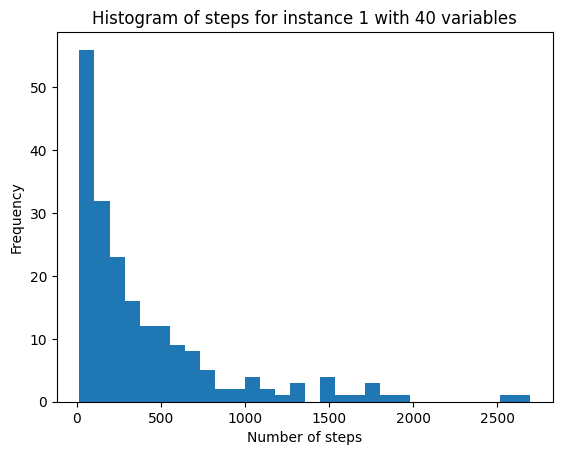

In [15]:
import matplotlib.pyplot as plt
plt.hist(instance_data['OUT_flips_count'], bins=30)
plt.title(f'Histogram of steps for instance {instance_id} with {instance_var} variables')
plt.xlabel('Number of steps')
plt.ylabel('Frequency')
plt.show()

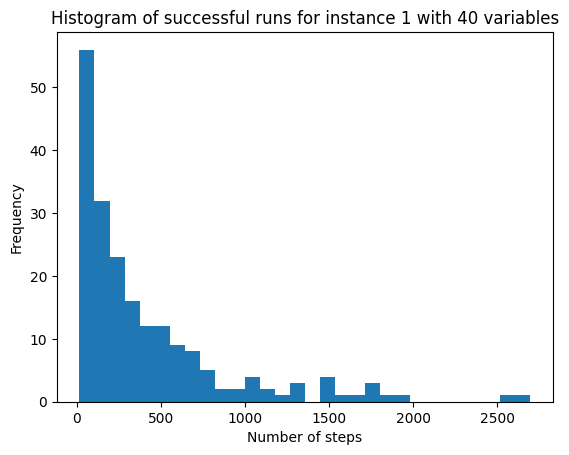

In [17]:
# show me success runs histogram
success_data = instance_data[instance_data['OUT_clause_satisfied'] == instance_data['INST_clause_total']]
plt.hist(success_data['OUT_flips_count'], bins=30)
plt.title(f'Histogram of successful runs for instance {instance_id} with {instance_var} variables')
plt.xlabel('Number of steps')
plt.ylabel('Frequency')
plt.show()

In [32]:
# avg number of steps for successful runs for each algorithm
avg_steps_gsat = instance_data_gsat[instance_data_gsat['OUT_clause_satisfied'] == instance_data_gsat['INST_clause_total']]['OUT_flips_count'].mean()
avg_steps_probsat = instance_data_probsat[instance_data_probsat['OUT_clause_satisfied'] == instance_data_probsat['INST_clause_total']]['OUT_flips_count'].mean()
print(f'Average steps for GSAT: {avg_steps_gsat}')
print(f'Average steps for probSAT: {avg_steps_probsat}')


Average steps for GSAT: 139.01
Average steps for probSAT: 99.09


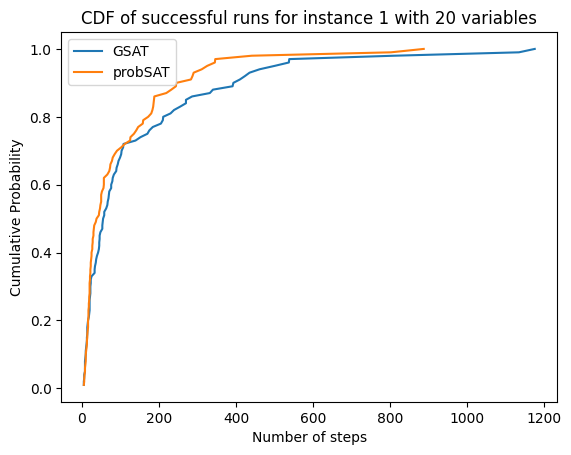

In [33]:
# CDF for successful runs
import numpy as np
def plot_cdf(data, label):
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
    plt.plot(sorted_data, yvals, label=label)
    
plt.figure()
plot_cdf(successful_runs[successful_runs['ALG_algorithm'] == 'GSAT']['OUT_flips_count'], 'GSAT')
plot_cdf(successful_runs[successful_runs['ALG_algorithm'] == 'probSAT']['OUT_flips_count'], 'probSAT')
plt.title(f'CDF of successful runs for instance {instance_id} with {instance_var} variables')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

In [34]:
# Penalized avg runtime
def penalized_avg_runtime(instance_data, penalty_factor=10):
    total_runs = instance_data.shape[0]
    successful_runs = instance_data[instance_data['OUT_clause_satisfied'] == instance_data['INST_clause_total']]
    num_successful_runs = successful_runs.shape[0]
    if num_successful_runs == 0:
        return penalty_factor * instance_data['ALG_max_flips'].iloc[0]
    avg_steps_successful = successful_runs['OUT_flips_count'].mean()
    penalized_avg = (num_successful_runs * avg_steps_successful + (total_runs - num_successful_runs) * penalty_factor * instance_data['ALG_max_flips'].iloc[0]) / total_runs
    return penalized_avg

par_gsat = penalized_avg_runtime(instance_data_gsat)
par_probsat = penalized_avg_runtime(instance_data_probsat)
print(f'Penalized Average Runtime for GSAT: {par_gsat}')
print(f'Penalized Average Runtime for probSAT: {par_probsat}')

Penalized Average Runtime for GSAT: 139.01
Penalized Average Runtime for probSAT: 99.09


In [38]:
# avg success rate per algorithm
def avg_success_rate(instance_data):
    total_runs = instance_data.shape[0]
    successful_runs = instance_data[instance_data['OUT_clause_satisfied'] == instance_data['INST_clause_total']]
    num_successful_runs = successful_runs.shape[0]
    return num_successful_runs / total_runs * 100

asr_gsat = avg_success_rate(instance_data_gsat)
asr_probsat = avg_success_rate(instance_data_probsat)
print(f'Average Success Rate for GSAT: {asr_gsat}%')
print(f'Average Success Rate for probSAT: {asr_probsat}%')

Average Success Rate for GSAT: 100.0%
Average Success Rate for probSAT: 100.0%
